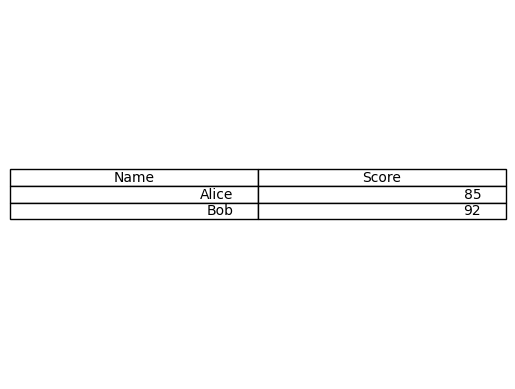

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
df = pd.DataFrame({
    'Name': ['Alice', 'Bob'],
    'Score': [85, 92]
})

# Create a figure and table
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df.values, colLabels=df.columns, loc='center')

# Save as PDF
plt.savefig('dataframe_table.pdf')


In [9]:
import re

def dms_to_decimal(dms_str):
    # Extract components using regex
    match = re.match(r"(\d+)°(\d+)'([\d.]+)\"?([NSEW])", dms_str.strip())
    if not match:
        raise ValueError(f"Invalid DMS format: {dms_str}")
    
    degrees, minutes, seconds, direction = match.groups()
    decimal = float(degrees) + float(minutes)/60 + float(seconds)/3600
    
    # Apply direction
    if direction in ['S', 'W']:
        decimal *= -1
    
    return decimal

# Example usage
coord = "104°33'47.032\"E"  # 2°16'60.000\"N
decimal_coord = dms_to_decimal(coord)
print(decimal_coord)  


104.56306444444444


In [49]:
def ddm_to_dd(ddm_str):
    import re

    # Extract degrees, minutes, and direction
    match = re.match(r"(\d+)°([\d\.]+)'([NSEW])", ddm_str)
    if not match:
        return None
    degrees, minutes, direction = match.groups()
    dd = float(degrees) + float(minutes) / 60
    if direction in ['S', 'W']:
        dd *= -1

    return dd


coord = "1°12.000'N"  # 1°50.700'N
decimal_coord1 = ddm_to_dd(coord)

coord = "104°23.000'E"  # 1°50.700'N
decimal_coord2 = ddm_to_dd(coord)


print([decimal_coord1, decimal_coord2])         

[1.2, 104.38333333333334]


In [27]:
import duckdb
from app.polygons import *


# install duckdb extensions
# wget http://extensions.duckdb.org/v1.2.0/linux_amd64_gcc4/spatial.duckdb_extension.gz
duckdb.sql("INSTALL spatial")

# loading spatial extension
# duckdb.sql("LOAD './app/spatial.duckdb_extension'")
duckdb.sql("LOAD spatial")

# df = duckdb.sql(f'''
#     SELECT mmsi, sog, cog, rot, trueHeading, ts, longitude, latitude
#     FROM "/Users/zultan/Downloads/datastorage/pyais_gold20230101.parquet" 
#     WHERE latitude <= 90 AND latitude >= -90 AND
#     ST_Within(ST_Point(longitude, latitude), ST_GeomFromGeoJSON({portlimit}))
#     ORDER BY ts
# ''').fetchdf()

ans = duckdb.sql(f'''
    SELECT ST_Within(ST_Point(103.76079333333334, 1.2911866666666667), ST_GeomFromGeoJSON({tssNouthbound_db})) as within_area
''').fetchall()

In [31]:
print(ans[0][0])

<class 'bool'>


In [55]:
import psycopg2

conn = psycopg2.connect(
    dbname="pnav",
    user="postgresadmin",
    password="m4r1t1m3",
    host="marineai.cxwk8yige5f2.ap-southeast-5.rds.amazonaws.com",
    port="5432"
)

cursor = conn.cursor()

query = """
    SELECT *
    FROM public.ais_vesselinzone
    WHERE zone = 11 AND "tsOut" IS NULL AND mmsi IN (
        SELECT mmsi
        FROM public.ais_vesselinzone
        WHERE zone = 2 AND "tsOut" IS NULL
    )
"""

cursor.execute(query)
results = cursor.fetchall()

for row in results:
    print(row)

cursor.close()
conn.close()

(627, datetime.datetime(2025, 8, 6, 16, 36, 58, 712000), 352004704, 0, 'Under way using engine', 101.02918666666666, 2.7776116666666666, datetime.datetime(2025, 8, 6, 18, 15, 51, 76000), None, 11)
(713, datetime.datetime(2025, 8, 6, 16, 37, 7, 667000), 352005680, 0, 'Under way using engine', 101.44878, 2.542081666666667, datetime.datetime(2025, 8, 6, 18, 16, 11, 107000), None, 11)
(900, datetime.datetime(2025, 8, 6, 16, 37, 17, 914000), 412328763, 15, 'Undefined or default', 101.28859, 2.649605, datetime.datetime(2025, 8, 6, 18, 16, 11, 509000), None, 11)
(892, datetime.datetime(2025, 8, 6, 16, 37, 17, 531000), 563162300, 0, 'Under way using engine', 101.47890666666666, 2.519738333333333, datetime.datetime(2025, 8, 6, 18, 16, 17, 191000), None, 11)
(645, datetime.datetime(2025, 8, 6, 16, 36, 59, 926000), 477401600, 0, 'Under way using engine', 101.10435, 2.72147, datetime.datetime(2025, 8, 6, 18, 16, 17, 422000), None, 11)
(724, datetime.datetime(2025, 8, 6, 16, 37, 9, 212000), 6360239

In [58]:
import pandas as pd
import psycopg2

conn = psycopg2.connect(
    dbname="pnav",
    user="postgresadmin",
    password="m4r1t1m3",
    host="marineai.cxwk8yige5f2.ap-southeast-5.rds.amazonaws.com",
    port="5432"
)

query = """
SELECT count(*)
FROM public.ais_vesselinzone
WHERE zone = 11 AND "tsOut" IS NULL AND mmsi IN (
    SELECT mmsi
    FROM public.ais_vesselinzone
    WHERE zone = 2 AND "tsOut" IS NULL
)
"""

df = pd.read_sql(query, conn)
print(df.head())
conn.close()

   count
0     20


/var/folders/js/qm0s0dss7jdfntd9fpkgvqxm0000gn/T/ipykernel_49121/1474528097.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [62]:
import streamlit as st
import plotly.express as px
import streamlit.components.v1 as components

# Create a Plotly chart
fig = px.scatter(
    x=[1, 2, 3, 4],
    y=[10, 20, 25, 30],
    title="Floating Chart"
)

# Export Plotly chart to HTML string
plot_html = fig.to_html(include_plotlyjs='cdn', full_html=False)

# Inject floating div with chart
components.html(f"""
    <div style="
        position: fixed;
        top: 20px;
        right: 20px;
        width: 400px;
        height: 300px;
        background-color: white;
        border: 1px solid #ccc;
        border-radius: 10px;
        box-shadow: 0 4px 8px rgba(0,0,0,0.2);
        z-index: 9999;
        overflow: hidden;
    ">
        {plot_html}
    </div>
""", height=320)

# Regular Streamlit content
st.title("Main App Content")
st.write("Scroll around — the chart floats in the corner.")


2025-08-08 13:06:49.093 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 13:06:49.144 
  command:

    streamlit run /opt/homebrew/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-08-08 13:06:49.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 13:06:49.144 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 13:06:49.145 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 13:06:49.145 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 13:06:49.146 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-08 13:06:49.146 Thread 'MainThread': mi

In [70]:
qry = ''

opt_sector = ["Sector 1", "Sector 2", "Sector 3", "Sector 4", "Sector 5", "Sector 6", "Sector 7", "Sector 8", "Sector 9"]
opt_tss = ["Northbound", "Southbound"]

selected_sector = []
selected_tss = ["Southbound"]       # "Northbound", "Southbound"

for idxs, sec in enumerate(opt_sector):
    sub_qry = ''
    main_qry = ''
    
    for idxt, tss in enumerate(opt_tss):
        output_col_name = f'Sec{(opt_sector.index(sec)) + 1}_{tss[0:5]}'

        # sector selected
        if sec in selected_sector:
            sub_qry = f'''
                SELECT mmsi
                FROM public.ais_vesselinzone
                WHERE zone = {(opt_sector.index(sec)) + 1} AND "tsOut" IS NULL             
            '''

            # tss selected
            if tss in selected_tss:
                main_qry = f'''
                    SELECT COUNT(*) AS "{output_col_name}"
                    FROM public.ais_vesselinzone
                    WHERE zone = {(opt_tss.index(tss)) + 10} AND "tsOut" IS NULL          
                ''' 

                qry += f'''
                    {sec.lower()[0:1]}{(opt_sector.index(sec)) + 1}{tss[0:1]} AS (
                        {main_qry} {'AND mmsi IN (' if sub_qry != '' else ''}
                            {sub_qry}
                        {')' if sub_qry != '' else ''}
                    ){',' if idxt == 0 or qry != '' else ''}
                ''' 
            else:
                qry += f'''
                    {sec.lower()[0:1]}{(opt_sector.index(sec)) + 1}{tss[0:1]} AS (
                        SELECT 0 AS "{output_col_name}"
                    ){',' if idxt == 0 or qry != '' else ''}
                '''                 

        else:
            qry += f'''
                {sec.lower()[0:1]}{(opt_sector.index(sec)) + 1}{tss[0:1]} AS (
                    SELECT 0 AS "{output_col_name}"
                ){',' if idxt == 0 or qry != '' else ''}
            '''



selc = '''
    SELECT *,
        ("Sec1_North" + "Sec1_South") AS "total_sec1",
        ("Sec2_North" + "Sec2_South") AS "total_sec2",
        ("Sec3_North" + "Sec3_South") AS "total_sec3",
        ("Sec4_North" + "Sec4_South") AS "total_sec4",
        ("Sec5_North" + "Sec5_South") AS "total_sec5",
        ("Sec6_North" + "Sec6_South") AS "total_sec6",
        ("Sec1_North" + "Sec2_North" + "Sec3_North"  + "Sec4_North" + "Sec5_North" + "Sec6_North") AS "total_tss_n",
        ("Sec1_South" + "Sec2_South" + "Sec3_South"  + "Sec4_South" + "Sec5_South" + "Sec6_South") AS "total_tss_s",
        ("Sec1_North" + "Sec1_South" + "Sec2_North" + "Sec2_South" + "Sec3_North" + "Sec3_South" + "Sec4_North" + "Sec4_South" + "Sec5_North" + "Sec5_South" + "Sec6_North" + "Sec6_South") AS "total"           
    FROM s1N, s1S,
        s2N, s2S,
        s3N, s3S,
        s4N, s4S,
        s5N, s5S,
        s6N, s6S
'''

qry = qry.strip()
query = 'WITH ' + qry[:len(qry)-1] + selc
print(query)


WITH s1N AS (
                    SELECT 0 AS "Sec1_North"
                ),
            
                s1S AS (
                    SELECT 0 AS "Sec1_South"
                ),
            
                s2N AS (
                    SELECT 0 AS "Sec2_North"
                ),
            
                s2S AS (
                    SELECT 0 AS "Sec2_South"
                ),
            
                s3N AS (
                    SELECT 0 AS "Sec3_North"
                ),
            
                s3S AS (
                    SELECT 0 AS "Sec3_South"
                ),
            
                s4N AS (
                    SELECT 0 AS "Sec4_North"
                ),
            
                s4S AS (
                    SELECT 0 AS "Sec4_South"
                ),
            
                s5N AS (
                    SELECT 0 AS "Sec5_North"
                ),
            
                s5S AS (
                    SELECT 0 AS "Sec5_South"
                ),
    

In [76]:
qry = ''

opt_sector = ["Sector 1", "Sector 2", "Sector 3", "Sector 4", "Sector 5", "Sector 6", "Sector 7", "Sector 8", "Sector 9"]
opt_tss = ["Northbound", "Southbound"]

selected_sector = ["Sector 1"]
selected_tss = ["Southbound"]       # "Northbound", "Southbound"


for idxs, sec in enumerate(opt_sector):
    sub_qry = ''
    main_qry = ''
    union = '''
        UNION
    '''
    
    for idxt, tss in enumerate(opt_tss):
        output_col_name = f'Sec{(opt_sector.index(sec)) + 1}_{tss[0:5]}'

        # sector selected
        if sec in selected_sector:
            sub_qry = f'''
                SELECT mmsi
                FROM public.ais_vesselinzone
                WHERE zone = {(opt_sector.index(sec)) + 1} AND "tsOut" IS NULL                    
            '''

            # tss selected
            if tss in selected_tss:
                main_qry = f'''
                    SELECT COUNT(*) AS "Count", 
                        s."shipType" AS "ShipTypeNo", 
                        CASE
                            WHEN s."shipTypeDesc" IS NULL THEN 'Not Available'
                            ELSE s."shipTypeDesc"
                        END AS "ShipType"
                    FROM public.ais_vesselinzone vz
                    LEFT JOIN public.ais_static s on s.mmsi = vz.mmsi
                    WHERE vz.zone = {(opt_tss.index(tss)) + 10} AND vz."tsOut" IS NULL AND vz.mmsi IN (
                        {sub_qry}
                    )
                    GROUP BY s."shipType", s."shipTypeDesc"        
                ''' 

                qry += (union if qry == '' else '') + main_qry
              

    print(qry)
    


        UNION
    
                    SELECT COUNT(*) AS "Count", 
                        s."shipType" AS "ShipTypeNo", 
                        CASE
                            WHEN s."shipTypeDesc" IS NULL THEN 'Not Available'
                            ELSE s."shipTypeDesc"
                        END AS "ShipType"
                    FROM public.ais_vesselinzone vz
                    LEFT JOIN public.ais_static s on s.mmsi = vz.mmsi
                    WHERE vz.zone = 11 AND vz."tsOut" IS NULL AND vz.mmsi IN (
                        
                SELECT mmsi
                FROM public.ais_vesselinzone
                WHERE zone = 1 AND "tsOut" IS NULL                    
            
                    )
                    GROUP BY s."shipType", s."shipTypeDesc"        
                

        UNION
    
                    SELECT COUNT(*) AS "Count", 
                        s."shipType" AS "ShipTypeNo", 
                        CASE
                            WHEN 

In [9]:
username = "zultan' --"
password = "123456"

In [10]:
query = text(f'''
    SELECT * 
    FROM user
    WHERE username = '{username}' and paswword = '{password}'
''')

In [11]:
print(query)


    SELECT * 
    FROM user
    WHERE username = 'zultan' --' and paswword = '123456'



In [3]:
from sqlalchemy import and_, or_, desc, text

In [ ]:
'''
SELECT COUNT(*) AS "{output_col_name}"
FROM public.ais_vesselinzone
WHERE zone = 1 AND "tsOut" IS NULL  AND mmsi IN (
	SELECT *
	FROM public.ais_vesselinzone
	WHERE zone = 11 AND "tsOut" IS NULL
	order by "tsDetected"
)

update public.ais_vesselinzone
set "tsOut" = now()
WHERE zone = 11 AND "tsDetected" < '2025-08-17'
'''